In [1]:
import pandas as pd
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
import nltk
from pprint import pprint

# Ensure you have the necessary NLTK data files
nltk.download('stopwords')

# Step 1: Load Data (Correct dataset 'labeled_comments_cleaned.csv')
data = pd.read_csv('labeled_comments_cleaned.csv')

# Step 2: Define Stop Words
custom_stop_words = set([
    "across", "et", "may", "would", "also", "please", "one", "first", "section", 
    "paragraph", "line", "use", "insert", "subsection", "general", "al", "specific"
])
stop_words = set(stopwords.words('english')).union(custom_stop_words)

# Step 3: Preprocessing - Tokenization and Stopwords Removal
def preprocess(text):
    tokens = gensim.utils.simple_preprocess(text)
    return [token for token in tokens if token not in stop_words]

# Apply preprocessing to the comments
data['processed_text'] = data['comment_full_text'].apply(preprocess)

# Step 4: Rebuild dictionary and corpus
dictionary = corpora.Dictionary(data['processed_text'])
corpus = [dictionary.doc2bow(text) for text in data['processed_text']]

# Step 5: Train the LDA Model with Custom Stop Words
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Step 6: Examine the Topics
pprint(lda_model.print_topics())

# Step 7: Calculate Topic Coherence Score to Evaluate Model Quality
coherence_model_lda = CoherenceModel(model=lda_model, texts=data['processed_text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"Topic Coherence Score: {coherence_lda}")

# Step 8: Assign Dominant Topic to Each Comment
data['dominant_topic'] = [max(lda_model[corpus[i]], key=lambda x: x[1])[0] for i in range(len(corpus))]

# Step 9: Save the Result with Assigned Topics
output_file = 'labeled_comments_with_lda_topics.csv'
data.to_csv(output_file, index=False)

print(f"Refined LDA topics assigned and results saved to {output_file}")


[nltk_data] Downloading package stopwords to /home/spati/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[(0,
  '0.018*"study" + 0.013*"project" + 0.012*"requirements" + 0.011*"bonds" + '
  '0.011*"page" + 0.009*"standard" + 0.008*"number" + 0.008*"bid" + '
  '0.008*"research" + 0.007*"subjects"'),
 (1,
  '0.016*"data" + 0.013*"read" + 0.010*"pfbs" + 0.010*"pfos" + '
  '0.010*"information" + 0.009*"risk" + 0.009*"pfhxs" + 0.008*"meetings" + '
  '0.008*"effects" + 0.008*"list"'),
 (2,
  '0.009*"bid" + 0.008*"add" + 0.007*"included" + 0.007*"see" + 0.006*"form" + '
  '0.006*"work" + 0.006*"total" + 0.006*"alternate" + 0.005*"www" + '
  '0.005*"information"'),
 (3,
  '0.010*"update" + 0.009*"work" + 0.008*"existing" + 0.008*"table" + '
  '0.007*"completed" + 0.007*"government" + 0.007*"end" + 0.007*"delete" + '
  '0.007*"criteria" + 0.007*"indexes"'),
 (4,
  '0.015*"table" + 0.011*"mtg" + 0.009*"committees" + 0.009*"mw" + '
  '0.008*"program" + 0.008*"name" + 0.008*"column" + 0.007*"must" + '
  '0.006*"necessary" + 0.006*"used"')]
Topic Coherence Score: 0.3513754637508756
Refined LDA topics 

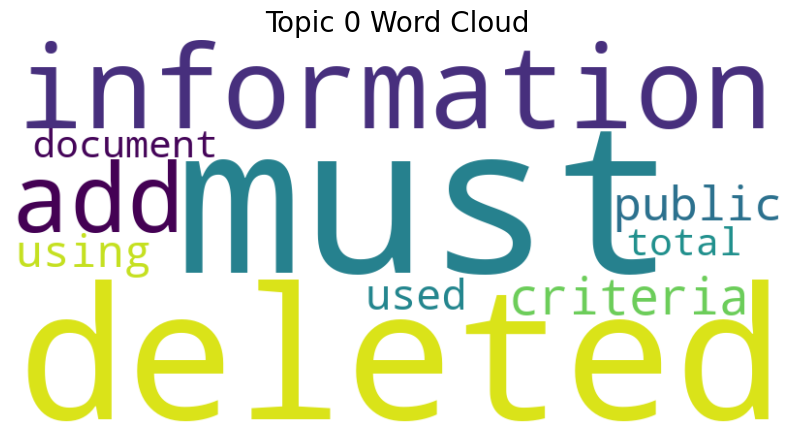

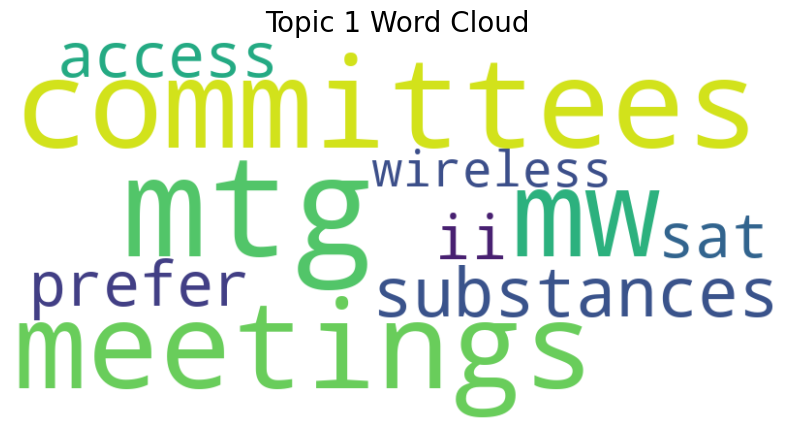

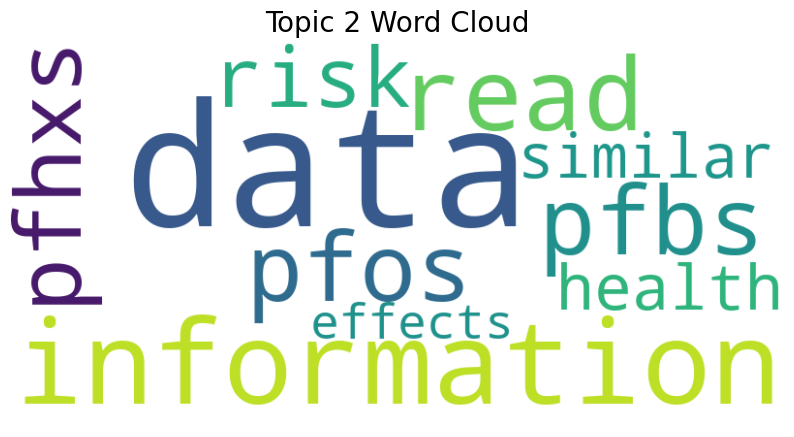

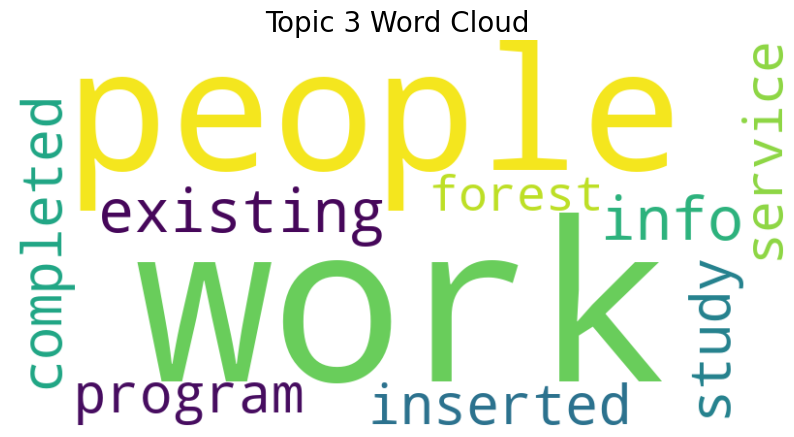

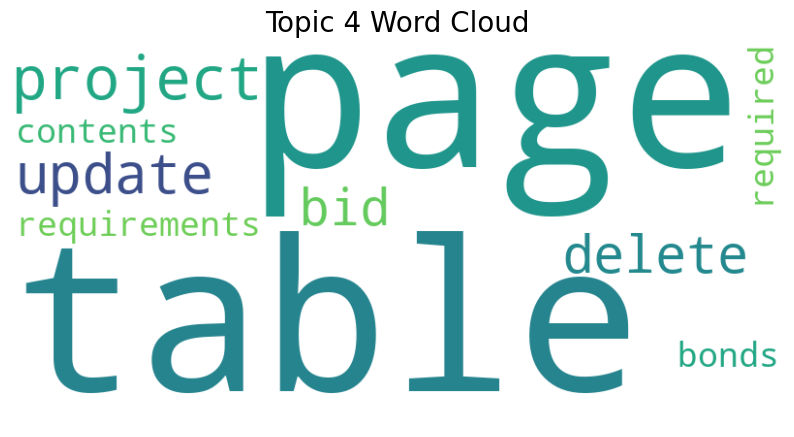

In [2]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Function to generate and display a word cloud for a given topic
def generate_word_cloud(topic_num, lda_model, num_words=10):
    topic_words = lda_model.show_topic(topic_num, num_words)
    word_dict = {word: weight for word, weight in topic_words}
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict)
    
    # Display the generated WordCloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic_num} Word Cloud", fontsize=20)
    plt.show()

# Generate word clouds for all topics
for i in range(lda_model.num_topics):
    generate_word_cloud(i, lda_model)


Topic 0: Project Management & Meetings
Key Words: project, mtg, page, table, requirements, bonds, update, committees, mw, meetings
Theme: This topic revolves around project management activities, updates, and formal meetings. It suggests that this is where discussions about project milestones, meeting agendas, documentation, and project-related requirements (e.g., bonds, committees) occur. This topic is focused on collaborative discussions related to managing and advancing a project.
Topic 1: Logistics, Bidding & Information Updates
Key Words: bid, add, info, code, work, words, link, date, inserted, city
Theme: This topic focuses on logistical aspects like bidding processes, work updates, and adding new information (e.g., codes, dates). It’s centered on more detailed administrative tasks like inserting data, linking documents, and tracking project logistics, likely related to city planning or project development.
Topic 2: Scientific Studies & Environmental Data
Key Words: study, read, information, data, pfbs, pfos, pfhxs, effects, substances, effect
Theme: This topic is clearly associated with scientific studies, environmental data, and research on specific substances (like PFBS, PFOS, etc.). It suggests that this topic involves discussions related to research findings, scientific effects, and the impact of certain substances on the environment.
Topic 3: Data Presentation & Health Documentation
Key Words: table, column, must, tables, used, see, name, act, health, document
Theme: This topic revolves around the presentation of data in tables, columns, and documents. It seems to be closely related to formal documentation, possibly in the health sector, where certain acts or standards must be adhered to. It involves mandatory documentation that requires careful formatting and adherence to regulations.
Topic 4: Work Progress & Task Completion
Key Words: work, similar, existing, people, completed, information, results, statement, non, two
Theme: This topic is focused on work progress, ongoing tasks, and comparing similar work. It discusses the completion of tasks, the results of ongoing efforts, and the existing conditions of projects. It reflects a focus on progress tracking, work updates, and project execution.
Key Takeaways:
Project Management & Meetings (Topic 0): Focuses on formal meetings, project updates, and management tasks.
Logistics & Bidding (Topic 1): Involves the logistics of bids, work codes, and inserting information.
Scientific Research (Topic 2): Deals with research, data analysis, and environmental effects of substances.
Data Presentation (Topic 3): Concentrates on tables, columns, and documentation, possibly related to health or compliance.
Work Progress (Topic 4): Revolves around work updates, comparing tasks, and reporting progress.
This division into themes is useful because it provides a framework for categorizing comments or collaborative document updates based on the nature of the discussion. For example:

Topic 0 would be relevant for comments about project direction and formal updates.
Topic 2 would be where research findings are discussed.

In [3]:
pip install pyLDAvis gensim


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import gensim

# Prepare the LDA model visualization
lda_vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(lda_vis_data)

In [6]:
import pandas as pd
import numpy as np
from pprint import pprint

# Step 1: Load your LDA model and data
# Assuming 'lda_model', 'dictionary', 'corpus', and 'comments_df' are already defined as per previous steps

# Step 2: Extract key terms for each topic from the LDA model
num_topics = lda_model.num_topics
num_words_per_topic = 10  # Number of words you want to display for each topic

topic_key_terms = {}
for topic_id in range(num_topics):
    topic_terms = lda_model.show_topic(topic_id, num_words_per_topic)
    topic_key_terms[topic_id] = ", ".join([term[0] for term in topic_terms])

# Step 3: Automatically generate descriptions based on key terms (simplified example)
# You can refine this section to generate more meaningful descriptions based on your domain knowledge
topic_descriptions = {}
for topic_id, key_terms in topic_key_terms.items():
    # Example approach: Use the first few words as a basic description, refine as needed
    description = f"Focuses on {', '.join(key_terms.split(', ')[:3])}..."
    topic_descriptions[topic_id] = description

# Step 4: Calculate percentage distribution of comments across topics
topic_counts = comments_df['dominant_topic'].value_counts(normalize=True) * 100

# Step 5: Prepare data for the table
lda_table_data = []
for topic_id in range(num_topics):
    lda_table_data.append({
        "LDA Topic": f"Topic {topic_id}",
        "Main Theme": topic_descriptions.get(topic_id, ""),
        "Key Terms": topic_key_terms.get(topic_id, ""),
        "Percentage of Comments": np.round(topic_counts.get(topic_id, 0), 2)
    })

# Convert to DataFrame for displaying as a table
lda_table_df = pd.DataFrame(lda_table_data)

# Display the resulting table
print(lda_table_df)

# Optionally, save the table to a CSV file for inclusion in your research paper
lda_table_df.to_csv('lda_topic_table_for_research.csv', index=False)


  LDA Topic                                Main Theme  \
0   Topic 0  Focuses on must, deleted, information...   
1   Topic 1         Focuses on mtg, committees, mw...   
2   Topic 2     Focuses on data, information, read...   
3   Topic 3      Focuses on work, people, existing...   
4   Topic 4        Focuses on table, page, project...   

                                           Key Terms  Percentage of Comments  
0  must, deleted, information, add, criteria, pub...                   25.19  
1  mtg, committees, mw, meetings, substances, pre...                   18.13  
2  data, information, read, pfos, pfbs, pfhxs, ri...                   18.29  
3  work, people, existing, info, completed, study...                   19.15  
4  table, page, project, update, delete, bid, req...                   19.23  


In [3]:
import pandas as pd
data=pd.read_csv('labeled_comments_with_lda_topics.csv')
data.head()

,file_id,comment_id,comment_date,anonymized_nickname,document_paragraph_text,document_selected_text,document_selected_sentences,comment_full_text,comment_sentence_text,is_sentence,...,next_action,level_0,level_1,level_2,level_3,level_4,date_column,time_column,processed_text,dominant_topic
0,ed88fa24-1a89-44fb-9a66-c7f554d87f5d,ffc97358-69e6-48fb-aaf0-6a844e26f653,2013-04-09 09:30:00+00:00 00:00:00+00:00,Editor,The experiments were carried out in a fluidize...,NaN,1.0,Ok?,Ok?,0,...,KEEP,INFORMATION EXCHANGE,REQUESTED,REQUESTING_CONFIRMATION,POTENTIAL_CHANGE,NaN,2013-04-09,09:30:00,['ok'],0
1,0c9c7a44-8bae-4bcf-a271-1b54ab0ef41e,ffa706dc-4877-492d-ac74-598d5f4d07c5,2011-12-08 15:51:00+00:00 00:00:00+00:00,Alicia R. Dalton-Tingler,"In addition to the work mentioned above, the E...",NaN,1.0,This has been discussed in the Executive Summa...,This has been discussed in the Executive Summa...,1,...,KEEP,MODIFICATION,EXECUTION,PROMISE,NaN,NaN,2011-12-08,15:51:00,"['discussed', 'executive', 'summary', 'via', '...",3
2,0c9c7a44-8bae-4bcf-a271-1b54ab0ef41e,ffa706dc-4877-492d-ac74-598d5f4d07c5,2011-12-08 15:51:00+00:00 00:00:00+00:00,Alicia R. Dalton-Tingler,"In addition to the work mentioned above, the E...",NaN,1.0,This has been discussed in the Executive Summa...,"It is, however, very out of place sitting here.",1,...,KEEP,SOCIAL COMMUNICATION,DISCUSSION,CONTENT,NOT_POTENTIAL_CHANGE,NaN,2011-12-08,15:51:00,"['discussed', 'executive', 'summary', 'via', '...",3
3,0c9c7a44-8bae-4bcf-a271-1b54ab0ef41e,ffa706dc-4877-492d-ac74-598d5f4d07c5,2011-12-08 15:51:00+00:00 00:00:00+00:00,Alicia R. Dalton-Tingler,"In addition to the work mentioned above, the E...",NaN,1.0,This has been discussed in the Executive Summa...,This has been discussed in the Executive Summa...,0,...,KEEP,MODIFICATION,REQUESTED,CONTENT,EXPLICIT,NaN,2011-12-08,15:51:00,"['discussed', 'executive', 'summary', 'via', '...",3
4,f5208894-9572-4cb8-b023-00b3c03cee89,ff533813-4050-424d-8e01-3c8dbb392f4d,2016-03-09 15:05:00+00:00 00:00:00+00:00,Alannah Kittle,NaN,NaN,1.0,CODING\n\nCode qualitative data for WAVGUAGE03A,CODING\n\nCode qualitative data for WAVGUAGE03A,0,...,KEEP,INFORMATION EXCHANGE,PROVIDED,REFERENCE,POTENTIAL_CHANGE,NaN,2016-03-09,15:05:00,"['coding', 'code', 'qualitative', 'data', 'wav...",1
